# Data cleaning

The task is to clear the text data of the crawled web-pages from different sites. 

It is necessary to ensure that the distribution of the 100 most frequent words includes only meaningful words in english language (not particles, conjunctions, prepositions, numbers, tags, symbols).

Determine the order of operations below and carry out the appropriate cleaning.

1. Remove non-english words
1. Remove html-tags (try to do it with regular expression, or play with beautifulsoap library)
1. Apply lemmatization / stemming
1. Remove stop-words
1. Additional processing - At your own initiative, if this helps to obtain a better distribution

#### Data reading

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords

from bs4 import BeautifulSoup
import re
from tqdm import tqdm

Exception ignored in: <function ARTM.__del__ at 0x000002D0E5606310>
Traceback (most recent call last):
  File "C:\BigARTM\python\artm\artm_model.py", line 252, in __del__
    self.dispose()
  File "C:\BigARTM\python\artm\artm_model.py", line 244, in dispose
    if self._master is not None:
AttributeError: 'ARTM' object has no attribute '_master'


#### Data processing

The dataset for this part can be downloaded here: `https://drive.google.com/file/d/1wLwo83J-ikCCZY2RAoYx8NghaSaQ-lBA/view?usp=sharing`

In [18]:
df_plain = pd.read_csv("web_sites_data.csv")

In [19]:
df_plain = df_plain[:1000:]

In [20]:
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Роман\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [21]:
def clean_text(html_page):
    # Remove html text
    soup = BeautifulSoup(html_page)
    soup = soup.get_text()

    # Remove some bad symbols
    text = re.sub(r"\n", " ", soup)

    # Lower case everything
    text = text.lower()

    # remove symbols and numbers
    text = re.sub(r"\xa0", " ", text)
    text = re.sub(r"[^A-Za-z]", " ", text)

    # Remove non-english words
    text = " ".join(w for w in nltk.wordpunct_tokenize(text)
                    if w.lower() in words or not w.isalpha())

    # tokenizing
    tokens = TreebankWordTokenizer().tokenize(text)

    # remove stop words
    stop_words = stopwords.words("english")
    tokens = [token for token in tokens if token not in stop_words]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # make a text
    text = " ".join(tokens)
    return text

In [22]:
df = pd.DataFrame(data={'text': df_plain.text.apply(clean_text)})

In [23]:
df.head()

,text
0,eric love war eric love war author eric title ...
1,eric short walk eric short walk author eric ti...
2,poetry unabridged poetry unabridged author tit...
3,uncle cabin uncle cabin author title uncle cab...
4,consider lily consider lily author title consi...


#### Vizualization

In [24]:
from collections import Counter
common_words = Counter(" ".join(df["text"]).split()).most_common(100)

In [25]:
y = [count for tag, count in common_words]
x = [tag for tag, count in common_words]

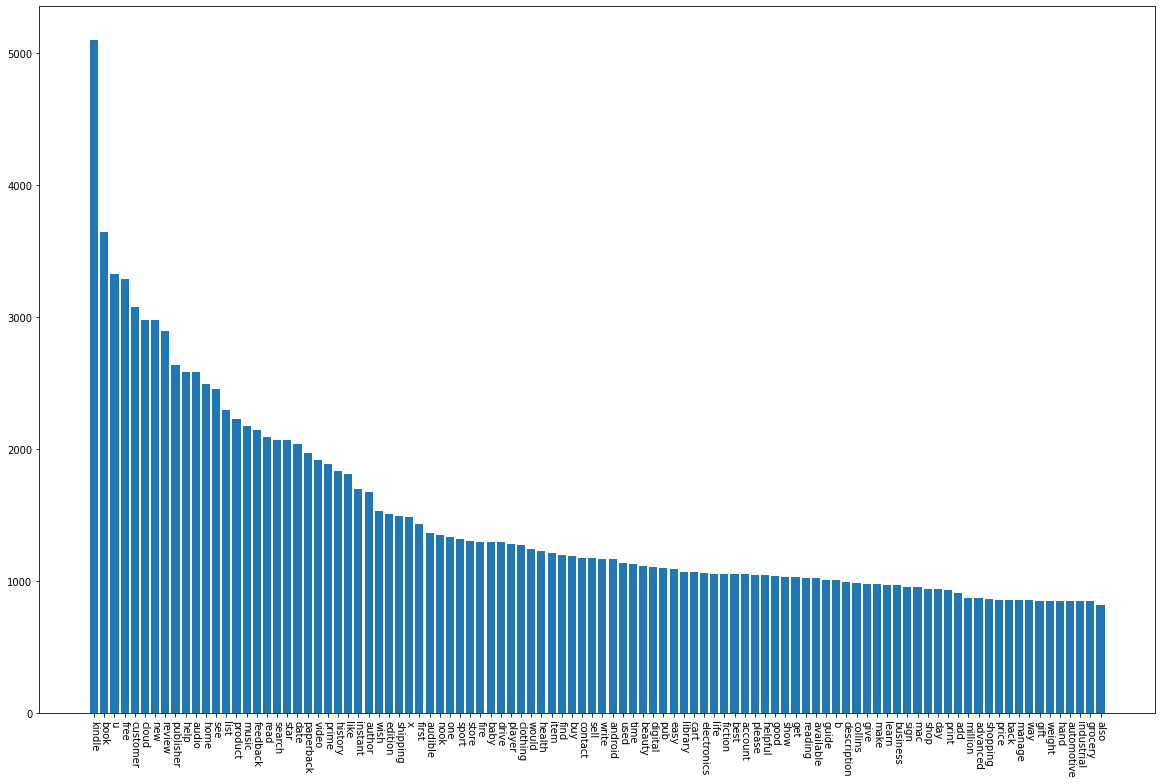

In [41]:
# via plt
plt.figure(figsize=(20, 13))
plt.bar(x, y)
plt.xticks(rotation=-90)
plt.show()

In [39]:
# via plotly
import plotly.express as px

fig = px.bar(x=x, y=y, title='100 most common words', width=2000, height=500)
fig.show()

#### Example of processed text

In [11]:
for i in range(2):
    print(df.loc[np.random.randint(1000)].text, "\n")

clubbable woman audio hill warren skip page content skip contact u help track order login register search book title author find book advanced search currency selection pound u dollar dollar cad dollar dollar dollar go basket quick basket view quantity book price total basket empty free delivery home free content navigation u coming soon fast book week book see large image clubbable woman audio author hill read warren unavailable sorry get title button link may title new window try add also available paperback short description clubbable woman hill first novel got back club wife even uncommunicative usual five later still front head full description publisher format audio see full bibliographic data crime people bought category showing height add basket cure add basket save death add basket save good morning midnight add basket save death jest book add basket save full description bibliographic data full description clubbable woman hill first novel got back club wife even uncommunicati

By these tokens we can only imagine what was the text about, but we can not exactly understand the theme of the text. For example, second text is about some stock market and its stocks volumes, highs, lows and etc. So, of course, a lot of context information were lost.

In [12]:
df_plain.loc[549].text

'<html>\n<head profile="http://www.w3.org/2005/10/profile">\n<LINK REL="SHORTCUT ICON" href="http://i.bookmooch.com/favicon.ico"> \n<link rel="icon" type="image/png" href="http://i.bookmooch.com/favicon.png">\n<title>Helga Hofmann : Butterflies and Moths of Britain and Europe (Collins Nature Guide)</title>\n<meta http-equiv="Content-Type" content="text/html">\n\t\n</head>\n<body bgcolor="#FFFFFF" leftmargin="0" topmargin="0" marginwidth="0" marginheight="0" text="#000000" link="#0000FF" vlink="#0000FF" alink="#FF0000" >\n<basefont face="arial, sans-serif"><font face="arial, sans-serif">\n<table width="100%" height="70" border="0" cellpadding="0" cellspacing="0">\n\t<tr><form action="/search" method="get">\n\t\t<td width="283" colspan="2" rowspan="2" bgcolor="#689A9B">\n\t\t\t<a href="/">\n\t\t\t\t<img src="http://i.bookmooch.com/images/bookmooch_logo.gif" width="283" height="66" border="0" alt="BookMooch logo"></a></td>\n\t\t<td width="675" height="38" colspan="9" align="right" bgcolor

# Duplicates detection. LSH

#### Library that I used

LSH - https://github.com/ekzhu/datasketch

1. Detect duplicated text (duplicates do not imply a complete word-to-word match, but texts that may contain a paraphrase, rearrangement of words, sentences)
1. Make a plot dependency of duplicates on shingle size (with fixed minhash length) 
1. Make a plot dependency of duplicates on minhash length (with fixed shingle size)

In [14]:
!pip install datasketch

You should consider upgrading via the 'C:\Users\Роман\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
from datasketch import MinHash, MinHashLSH
from tqdm.notebook import tqdm

In [196]:
def get_shingles(text, char_ngram=5):
    """Create a set of overlapping character n-grams.

    Only full length character n-grams are created, that is the first character
    n-gram is the first `char_ngram` characters from text, no padding is applied.

    Each n-gram is spaced exactly one character apart.

    Parameters
    ----------

    text: str
        The string from which the character n-grams are created.

    char_ngram: int (default 5)
        Length of each character n-gram.
    """
    return set(text[head:head + char_ngram] for head in range(0, len(text) - char_ngram))

In [224]:
N = 1000

In [263]:
shingles = [3, 5, 7, 9, 12]
hash_size = [32, 64, 128, 256]

In [264]:
dt = {}
for k in shingles:
    # calculate hash for every text
    hash_vector = []
    for i in range(N):
        text = df.loc[i].text
        shingles_text = get_shingles(text, k)
        m = MinHash(num_perm=64)
        for d in shingles_text:
            m.update(d.encode('utf8'))
        hash_vector.append(m)

    s = 0
    for i in tqdm(range(N)):
        # if Jaccard similarity more than 0.75 I consider texts as dublicates
        lsh = MinHashLSH(threshold=0.75, num_perm=64)
        for j in range(i+1, N):
            lsh.insert(f"hash{j}", hash_vector[j])

        s += len(lsh.query(hash_vector[i]))

    dt[k] = s

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

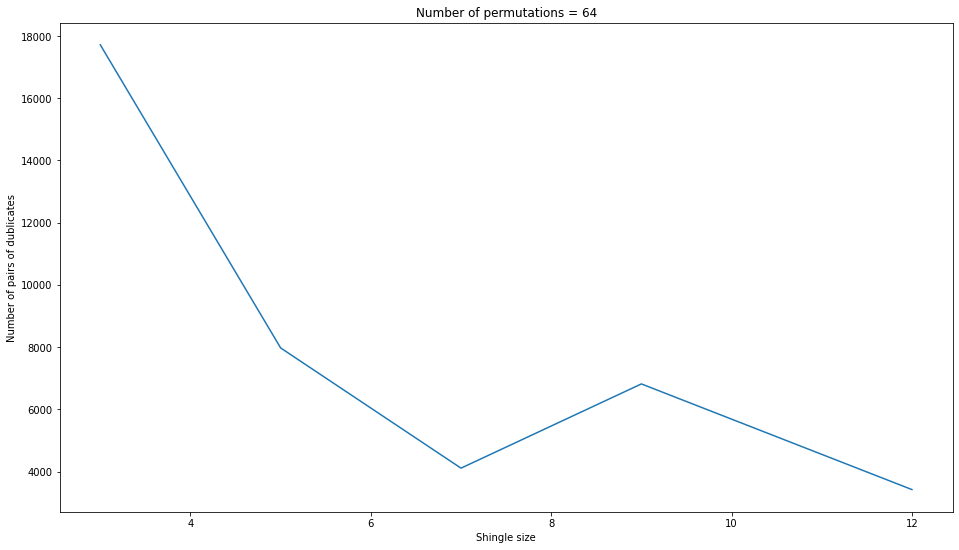

In [265]:
plt.figure(figsize=(16,9))
plt.xlabel("Shingle size")
plt.ylabel("Number of pairs of dublicates")
plt.title("Number of permutations = 64")
plt.plot(dt.keys(), dt.values())
plt.show()

### With increasing shingle size, number of dublicates is decreasing. That happens because of more "word-like" shingles. Also, big shingle size like 9 or 12 leads to unexpected results, I think because shingles will be like incomprehensible garbage. For better result, you better use shingle size = 5 or 7

In [261]:
dt = {}
for perm in hash_size:
    # calculate hash for every text
    hash_vector = []
    for i in range(N):
        text = df.loc[i].text
        shingles_text = get_shingles(text, 5)
        m = MinHash(num_perm=perm)
        for d in shingles_text:
            m.update(d.encode('utf8'))
        hash_vector.append(m)

    s = 0
    for i in tqdm(range(N)):
        lsh = MinHashLSH(threshold=0.75, num_perm=perm)
        for j in range(i+1, N):
            lsh.insert(f"hash{j}", hash_vector[j])

        s += len(lsh.query(hash_vector[i]))

    dt[perm] = s

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

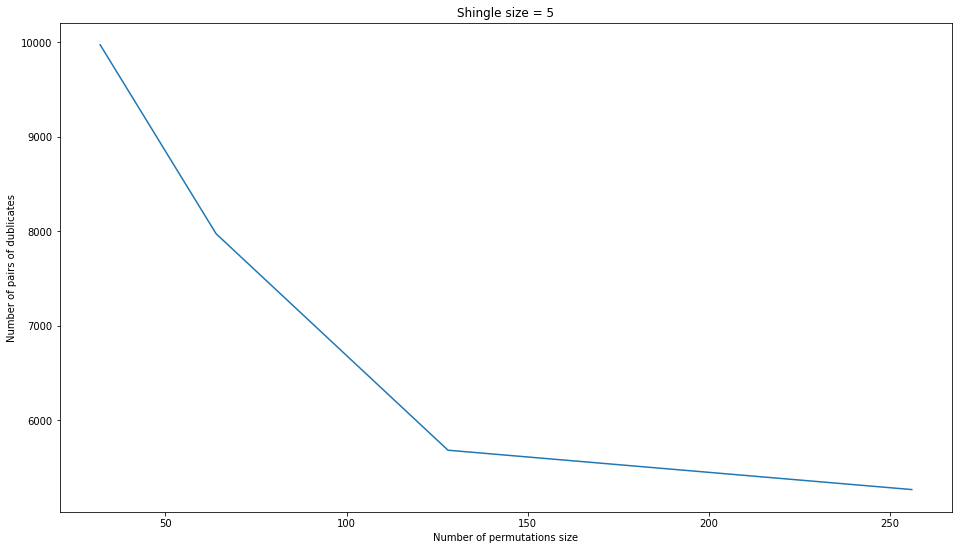

In [262]:
plt.figure(figsize=(16, 9))
plt.xlabel("Number of permutations size")
plt.ylabel("Number of pairs of dublicates")
plt.title("Shingle size = 5")
plt.plot(dt.keys(), dt.values())
plt.show()

### With increasing permutation number, number of dublicates is decreasing. That happens because of lower amount of collisions due to bigger hash size. In addition, computational time also doubles with doubling permutation number.

# Topic model

The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: `https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing`

In [46]:
data = pd.read_csv("data.csv")
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [42]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')

C:\Users\Роман\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Роман\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^A-Za-z]", " ", text)
    
    # tokenizing
    tokens = TreebankWordTokenizer().tokenize(text)

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    
    return result

In [47]:
doc_sample = data.text[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


 tokenized and lemmatized document: 
['process', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'circuit', 'return', 'point', 'aware', 'fact', 'perfectly', 'uniform', 'wall']


In [48]:
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [49]:
data_processed = pd.DataFrame(
    data={'text': [preprocess(data.loc[i].text) for i in range(data.shape[0])],
          'author': data.author
          })

In [50]:
data_processed

,text,author
0,"[process, afforded, means, ascertaining, dimen...",EAP
1,"[occurred, fumbling, mere, mistake]",HPL
2,"[left, hand, gold, snuff, capered, hill, cutti...",EAP
3,"[lovely, spring, looked, windsor, terrace, six...",MWS
4,"[finding, gold, superintendent, abandoned, att...",HPL
...,...,...
19574,"[fancied, looked, eminent, landscape, painter,...",EAP
19575,"[lids, clenched, spasm]",EAP
19576,"[mais, faut, agir, frenchman, faints, outright]",EAP
19577,"[item, news, like, strikes, coolly, received]",EAP


Plotting the histogram of resulting tokens counts in the processed datasets.

In [51]:
text = [item for sublist in data_processed.text for item in sublist]

In [52]:
from collections import Counter
common_words = Counter(text).most_common(100)

import plotly.express as px
y = [count for tag, count in common_words]
x = [tag for tag, count in common_words]
fig = px.bar(x=x, y=y, title='100 most common words', width=2000, height=500)
fig.show()

#### NMF

Topic modeling with NMF.

In [410]:
from operator import itemgetter
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
dictionary = gensim.corpora.Dictionary(data_processed.text)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in data_processed.text]

In [399]:
coherence_scores = []
topic_nums = list(np.arange(5, 41, 5))

for num in tqdm(topic_nums):
    nmf = models.Nmf(
        corpus=corpus_tfidf,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=2,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=data_processed.text,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

  0%|          | 0/8 [00:00<?, ?it/s]

In [401]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))

print(scores)

[(5, 0.20519), (10, 0.26541), (15, 0.27247), (20, 0.29413), (25, 0.33219), (30, 0.35114), (35, 0.3852), (40, 0.38119)]


According to the coherence metric, we should make 35 topics

In [407]:
nmf = models.Nmf(
        corpus=corpus_tfidf,
        num_topics=35,
        id2word=dictionary,
        chunksize=2000,
        passes=2,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

for idx, topic in nmf.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.114*"little" + 0.077*"return" + 0.015*"point" + 0.015*"reason" + 0.014*"life" + 0.014*"possible" + 0.014*"times" + 0.013*"home" + 0.012*"question" + 0.008*"promise"

Topic: 1 Word: 0.068*"dream" + 0.043*"great" + 0.037*"child" + 0.023*"grew" + 0.022*"face" + 0.021*"born" + 0.021*"called" + 0.018*"wall" + 0.015*"continued" + 0.015*"dark"

Topic: 2 Word: 0.099*"heart" + 0.043*"looked" + 0.032*"think" + 0.028*"fear" + 0.023*"returned" + 0.019*"remember" + 0.019*"imagination" + 0.018*"days" + 0.017*"raymond" + 0.015*"perdita"

Topic: 3 Word: 0.280*"said" + 0.040*"world" + 0.030*"dead" + 0.017*"dupin" + 0.016*"replied" + 0.013*"certainly" + 0.010*"alas" + 0.008*"knowledge" + 0.007*"better" + 0.007*"wish"

Topic: 4 Word: 0.073*"thing" + 0.058*"love" + 0.030*"looked" + 0.025*"length" + 0.016*"remained" + 0.012*"subject" + 0.011*"despair" + 0.011*"till" + 0.011*"guess" + 0.011*"sought"

Topic: 5 Word: 0.082*"course" + 0.052*"earth" + 0.038*"life" + 0.023*"fact" + 0.020*"doubt"

#### LDA

Topic modeling with LDA.

In [409]:
coherence_scores = []
topic_nums = list(np.arange(5, 41, 5))

for num in tqdm(topic_nums):
    LDA = models.LdaMulticore(
        corpus_tfidf, 
        num_topics=35, 
        id2word=dictionary, 
        passes=2
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=LDA,
        texts=data_processed.text,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))

print(scores)

  0%|          | 0/8 [00:00<?, ?it/s]

[(5, 0.39373), (10, 0.43747), (15, 0.39229), (20, 0.41082), (25, 0.39201), (30, 0.41112), (35, 0.40038), (40, 0.39399)]


According to coherence score, most useful topic number is 10

In [430]:
lda_model_tfidf = models.LdaMulticore(
        corpus_tfidf, 
        num_topics=10, 
        id2word=dictionary, 
        passes=2
    )

In [431]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.005*"hand" + 0.004*"know" + 0.003*"hours" + 0.003*"soon" + 0.003*"little" + 0.003*"life" + 0.003*"shall" + 0.003*"time" + 0.003*"great" + 0.003*"kind"

Topic: 1 Word: 0.005*"thought" + 0.005*"matter" + 0.004*"long" + 0.004*"little" + 0.004*"time" + 0.004*"life" + 0.003*"case" + 0.003*"said" + 0.003*"length" + 0.003*"like"

Topic: 2 Word: 0.006*"know" + 0.005*"love" + 0.003*"black" + 0.003*"like" + 0.003*"look" + 0.003*"right" + 0.003*"nature" + 0.003*"replied" + 0.003*"come" + 0.003*"question"

Topic: 3 Word: 0.004*"eyes" + 0.003*"house" + 0.003*"went" + 0.003*"night" + 0.003*"father" + 0.003*"said" + 0.003*"little" + 0.003*"seen" + 0.003*"soon" + 0.003*"time"

Topic: 4 Word: 0.006*"said" + 0.004*"words" + 0.004*"looked" + 0.004*"shall" + 0.003*"means" + 0.003*"time" + 0.003*"nearly" + 0.003*"long" + 0.003*"small" + 0.002*"know"

Topic: 5 Word: 0.005*"said" + 0.004*"shall" + 0.004*"thing" + 0.003*"fear" + 0.003*"night" + 0.003*"like" + 0.003*"death" + 0.003*"remember" 